# Spotify Genre Classifier

## Setup

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from os import walk, path

from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import stats

In [2]:
# load data

# get all filenames from the directory data
f = []
for (dirpath, dirnames, filenames) in walk("data"):
    f.extend(filenames)
    break

# load data from all files from the directory data
frames = []
for file in f:
    data = pd.read_json(path.join("data", file))
    frames.append(data)

# concat all data into one dataframe
raw_data = pd.concat(frames, ignore_index=True)

## Visualization

### Clean Dataset

In [3]:
raw_data.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0        0.1940  0.0324    5   -28.215     1       0.0382         0.982   
1        0.0807  0.0114    0   -20.451     1       0.0461         0.824   
2        0.4250  0.0363    1   -21.629     0       0.0686         0.991   
3        0.3740  0.0368    9   -28.556     0       0.0421         0.988   
4        0.1020  0.0259    8   -30.196     0       0.0444         0.964   

   instrumentalness  liveness  valence    tempo            type  \
0           0.96100    0.0916   0.0596  144.130  audio_features   
1           0.69000    0.1000   0.0556   79.737  audio_features   
2           0.00109    0.2500   0.7450   78.991  audio_features   
3           0.90800    0.1770   0.1220   63.895  audio_features   
4           0.86400    0.0972   0.0319   90.128  audio_features   

                       id                                   uri  \
0  2YarjDYjBJuH63dUIh9OWv  spotify:track:2YarjDYjBJuH63dUIh9OWv   
1  3yeEHZQ3ubZ0hYjbq6VpW7  spotify:track:3yeEHZQ3ubZ0hYjbq6VpW7   
2  1AKdBq4wtJKU9DhQpekvtc  spotify:track:1AKdBq4wtJKU9DhQpekvtc   
3  6IihP5ExawBf9ddqN5fO6k  spotify:track:6IihP5ExawBf9ddqN5fO6k   
4  1oMtwEc8xjDTNarCsMlI8B  spotify:track:1oMtwEc8xjDTNarCsMlI8B   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2YarjDYjBJuH...   
1  https://api.spotify.com/v1/tracks/3yeEHZQ3ubZ0...   
2  https://api.spotify.com/v1/tracks/1AKdBq4wtJKU...   
3  https://api.spotify.com/v1/tracks/6IihP5ExawBf...   
4  https://api.spotify.com/v1/tracks/1oMtwEc8xjDT...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/2Yar...       433800   
1  https://api.spotify.com/v1/audio-analysis/3yeE...       385080   
2  https://api.spotify.com/v1/audio-analysis/1AKd...       143777   
3  https://api.spotify.com/v1/audio-analysis/6Iih...       119053   
4  https://api.spotify.com/v1/audio-analysis/1oMt...       644333   

   time_signature    genre             playlist_id  
0               4  classic  37i9dQZF1DXaHEllsiT8lf  
1               4  classic  37i9dQZF1DXaHEllsiT8lf  
2               4  classic  37i9dQZF1DXaHEllsiT8lf  
3               3  classic  37i9dQZF1DXaHEllsiT8lf  
4               4  classic  37i9dQZF1DXaHEllsiT8lf

In [4]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'playlist_id'],
      dtype='object')

In [5]:
raw_data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'playlist_id'],
      dtype='object')

In [6]:
raw_data.shape

(2580, 20)

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      2580 non-null   float64
 1   energy            2580 non-null   float64
 2   key               2580 non-null   int64  
 3   loudness          2580 non-null   float64
 4   mode              2580 non-null   int64  
 5   speechiness       2580 non-null   float64
 6   acousticness      2580 non-null   float64
 7   instrumentalness  2580 non-null   float64
 8   liveness          2580 non-null   float64
 9   valence           2580 non-null   float64
 10  tempo             2580 non-null   float64
 11  type              2580 non-null   object 
 12  id                2580 non-null   object 
 13  uri               2580 non-null   object 
 14  track_href        2580 non-null   object 
 15  analysis_url      2580 non-null   object 
 16  duration_ms       2580 non-null   int64  


In [8]:
# if you want to compare statistic informations from specific features you can use: data.groupby('genre').describe()["feature1", "feature2", ...]
raw_data.groupby(raw_data["genre"]).describe()["energy"]

count      mean       std       min      25%     50%      75%    max
genre                                                                        
classic  509.0  0.075041  0.092353  0.000707  0.01330  0.0405  0.10100  0.606
edm      502.0  0.844637  0.099962  0.271000  0.78500  0.8610  0.92350  0.998
hiphop   524.0  0.672517  0.141917  0.248000  0.56575  0.6735  0.78600  0.952
jazz     531.0  0.261284  0.186400  0.007560  0.10700  0.2190  0.39350  0.783
rock     514.0  0.796501  0.157817  0.099300  0.70900  0.8480  0.91775  0.998

### Plots

In [17]:
raw_data_plots = raw_data.copy()
raw_data_plots.drop(["uri", "id", "track_href", "analysis_url", "type", "playlist_id"], axis=1, inplace=True)

In [18]:
raw_data_plots.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre'],
      dtype='object')

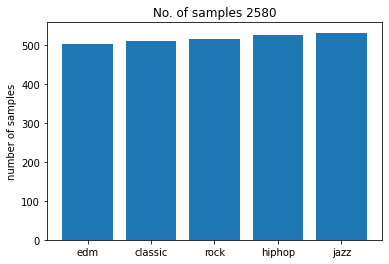

In [13]:
sorted_list = raw_data_plots["genre"].value_counts().sort_values()
labels = sorted_list.index.tolist()
values = sorted_list.tolist()

plt.bar(labels, values)
plt.title(f"No. of samples {raw_data.shape[0]}")
plt.ylabel("number of samples")
plt.show()

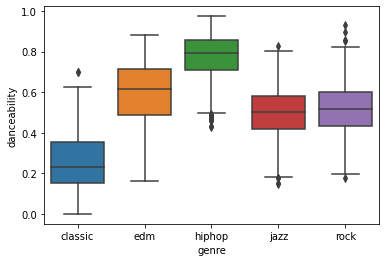

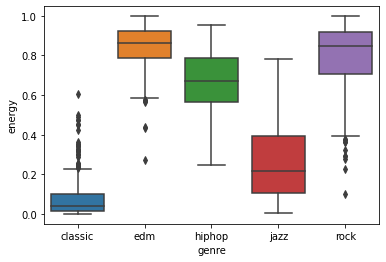

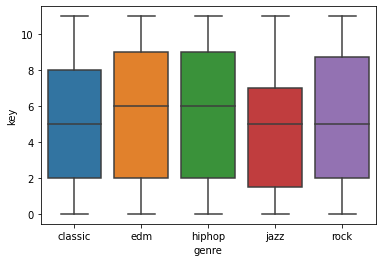

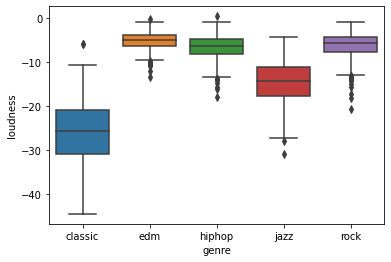

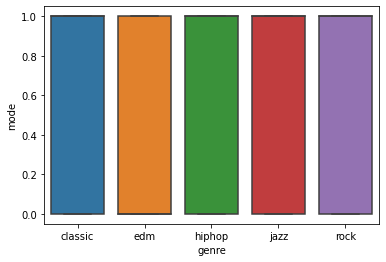

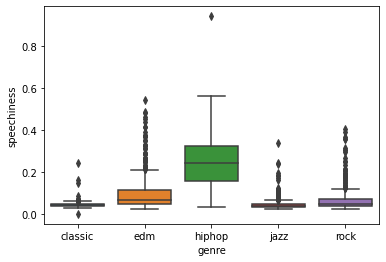

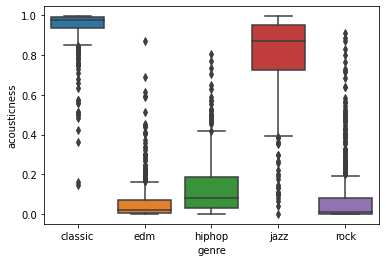

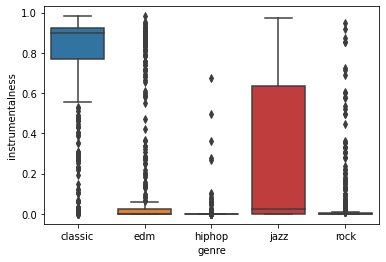

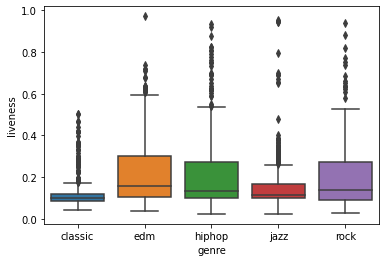

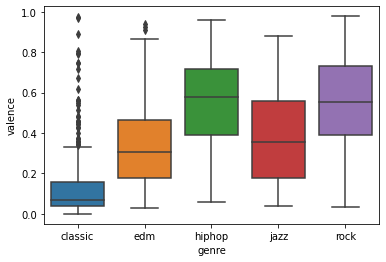

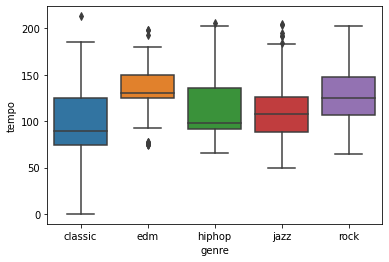

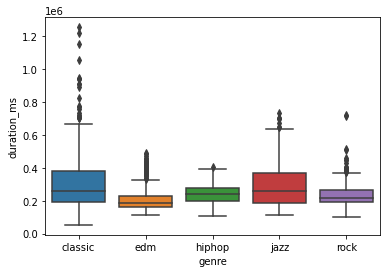

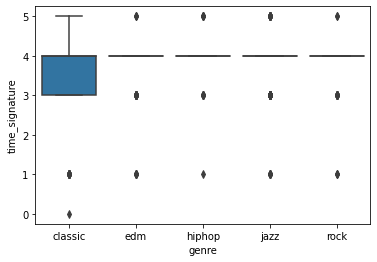

In [24]:
for feature in raw_data_plots.iloc[:,:13].columns:
    sns.boxplot(x="genre", y=feature, data=raw_data_plots)
    plt.show()

In [31]:
raw_data_plots.iloc[:,:13].corr()

danceability    energy       key  loudness      mode  \
danceability          1.000000  0.508434  0.058635  0.595529 -0.095916   
energy                0.508434  1.000000  0.081617  0.885353 -0.087170   
key                   0.058635  0.081617  1.000000  0.055878 -0.171030   
loudness              0.595529  0.885353  0.055878  1.000000 -0.109720   
mode                 -0.095916 -0.087170 -0.171030 -0.109720  1.000000   
speechiness           0.438739  0.321033  0.081176  0.320183 -0.067529   
acousticness         -0.560218 -0.909642 -0.078365 -0.819818  0.070845   
instrumentalness     -0.494145 -0.584728 -0.022697 -0.687890  0.078447   
liveness              0.103490  0.271978  0.056277  0.259187 -0.033023   
valence               0.605796  0.491460  0.023199  0.516020 -0.021189   
tempo                 0.094779  0.380785  0.033592  0.349584 -0.036095   
duration_ms          -0.226999 -0.221078 -0.042316 -0.221741  0.050218   
time_signature        0.274162  0.227447  0.021013  0.234602 -0.033781   

                  speechiness  acousticness  instrumentalness  liveness  \
danceability         0.438739     -0.560218         -0.494145  0.103490   
energy               0.321033     -0.909642         -0.584728  0.271978   
key                  0.081176     -0.078365         -0.022697  0.056277   
loudness             0.320183     -0.819818         -0.687890  0.259187   
mode                -0.067529      0.070845          0.078447 -0.033023   
speechiness          1.000000     -0.376673         -0.325059  0.144719   
acousticness        -0.376673      1.000000          0.604104 -0.246787   
instrumentalness    -0.325059      0.604104          1.000000 -0.209727   
liveness             0.144719     -0.246787         -0.209727  1.000000   
valence              0.266144     -0.448043         -0.496513  0.123547   
tempo                0.075178     -0.345663         -0.227791  0.084672   
duration_ms         -0.124306      0.243134          0.271780 -0.098341   
time_signature       0.092624     -0.222854         -0.184943  0.067279   

                   valence     tempo  duration_ms  time_signature  
danceability      0.605796  0.094779    -0.226999        0.274162  
energy            0.491460  0.380785    -0.221078        0.227447  
key               0.023199  0.033592    -0.042316        0.021013  
loudness          0.516020  0.349584    -0.221741        0.234602  
mode             -0.021189 -0.036095     0.050218       -0.033781  
speechiness       0.266144  0.075178    -0.124306        0.092624  
acousticness     -0.448043 -0.345663     0.243134       -0.222854  
instrumentalness -0.496513 -0.227791     0.271780       -0.184943  
liveness          0.123547  0.084672    -0.098341        0.067279  
valence           1.000000  0.127124    -0.149246        0.229734  
tempo             0.127124  1.000000    -0.156068        0.046957  
duration_ms      -0.149246 -0.156068     1.000000       -0.056560  
time_signature    0.229734  0.046957    -0.056560        1.000000

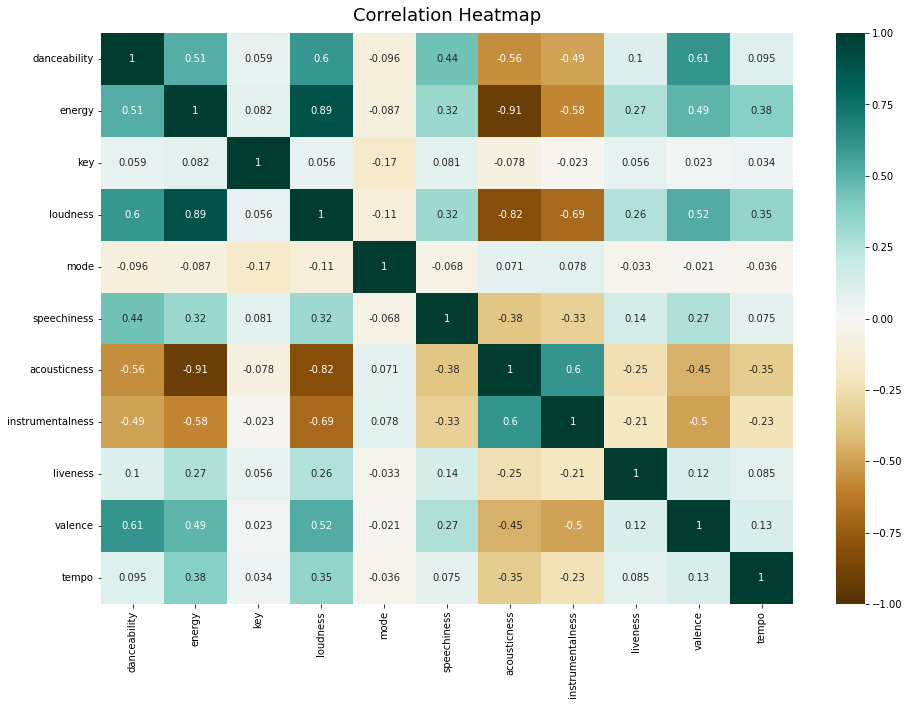

In [ ]:
fig = plt.figure()
heatmap = sns.heatmap(raw_data_plots.iloc[:,:13].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

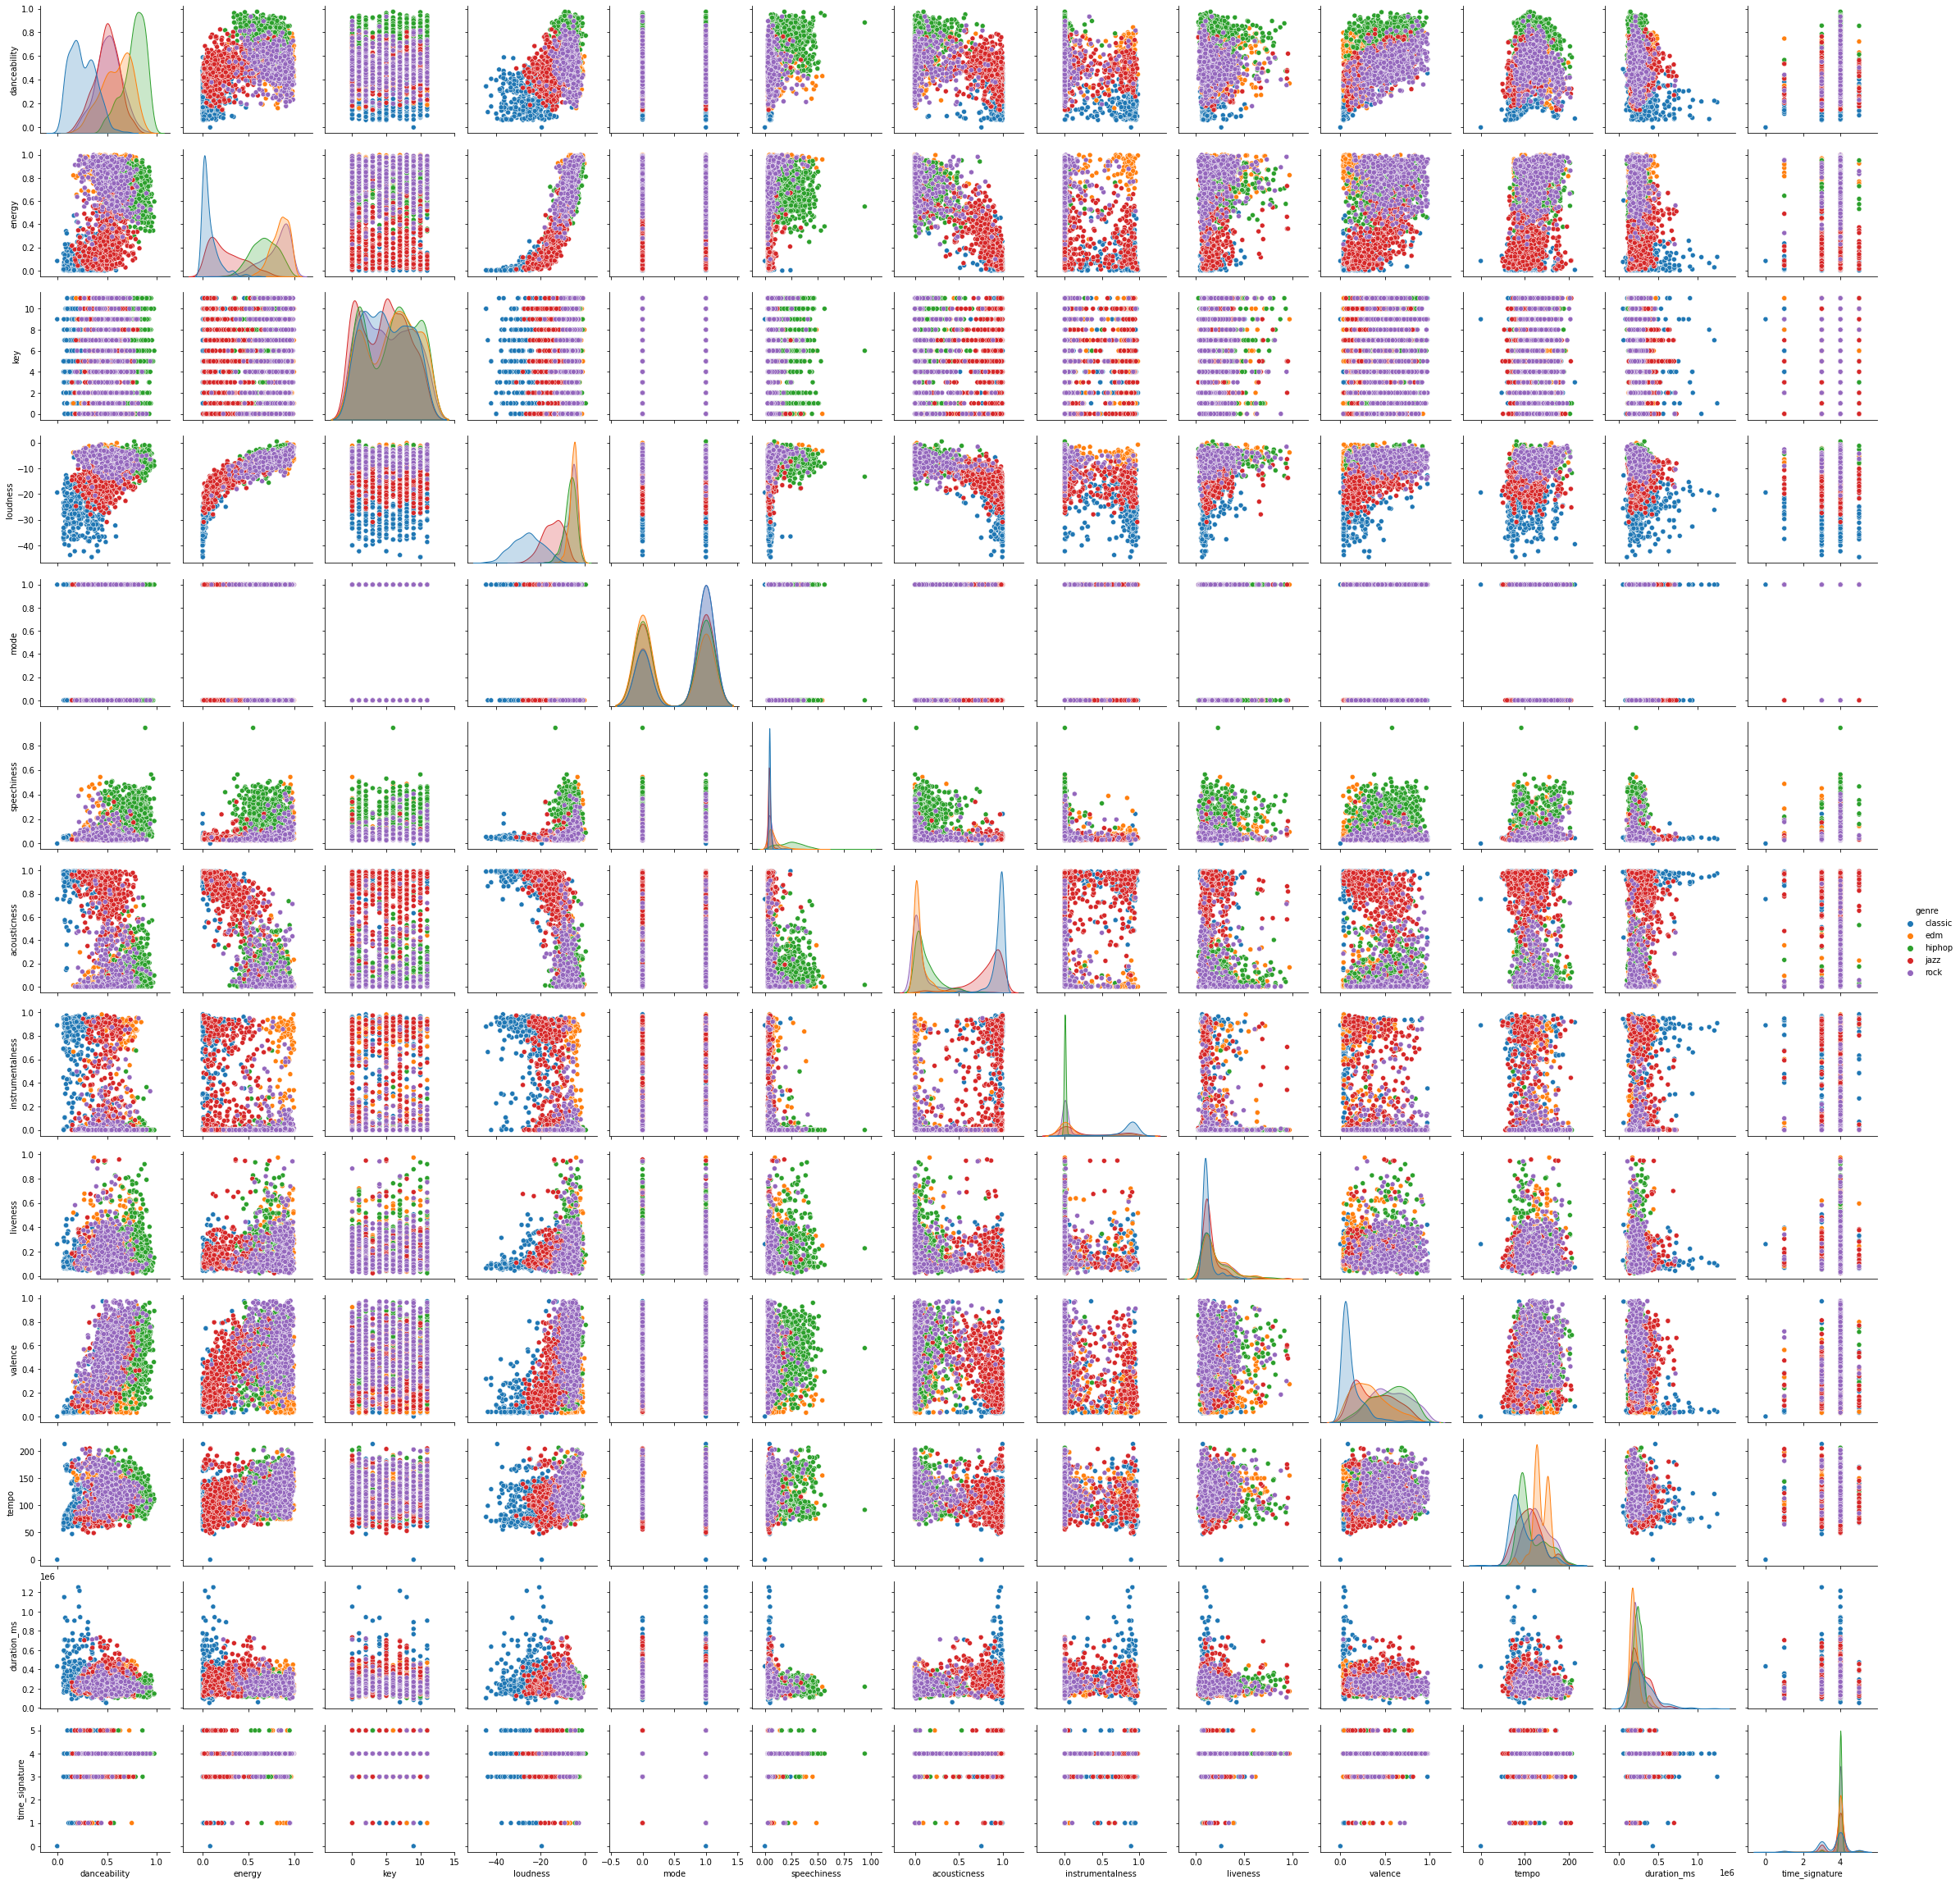

In [34]:
sns.pairplot(data=raw_data_plots, hue="genre")

## Preprocessing

In [3]:
numeric_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"]
categorical_features = ["key", "mode", "time_signature"]
features = numeric_features + categorical_features

Get the maximum and minimum data value within the boxplot whiskers

In [4]:
iqr_factor = 1.5

def getQuartiles(data: pd.DataFrame) -> set:
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return Q1, Q3, IQR

def getMaxWhiskerValue(data: pd.Series) -> float:
    Q1, Q3, IQR = getQuartiles(data)
    whisker_value = Q3 + (IQR * iqr_factor)
    return whisker_value

def getMinWhiskerValue(data: pd.Series) -> float:
    Q1, Q3, IQR = getQuartiles(data)
    whisker_value = Q1 - (IQR * iqr_factor)
    return whisker_value

Find correlated features where the correlation coefficient is above a specific threshold

In [5]:
def find_correlated_features(data:pd.DataFrame, threshold:float) -> list:
    correlation_matrix = data.corr().abs()
    avg_correlation = correlation_matrix.mean(axis = 1)
    up = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    drop = list()
        
    for row in range(len(up)-1):
        for col in range (row + 1, len(up)):
            if(correlation_matrix.iloc[row, col] > threshold):
                if(avg_correlation.iloc[row] > avg_correlation.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop = list(set(drop)) 
    dropcols_names = list(data.columns[[item for item in drop]])
    
    return dropcols_names

Remove samples with key == -1

In [6]:
def removeSamplesWithInvalidKey(data: pd.DataFrame) -> None:
    old_len = len(data)
    data = data[data.key != -1]
    print("Samples removed because of invalid key:", old_len - len(data))

Remove samples where time_signature is out of bounds [3:7]

In [7]:
def removeSamplesWithInvalidTimeSignature(data: pd.DataFrame) -> None:
    old_len = len(data)
    data = data[(data.time_signature >= 3) & (data.time_signature <= 7)]
    print("Samples removed because of invalid time_signature:", old_len - len(data))

**Perform all preprocessing steps on the training data**

In [8]:
def preprocessTrainingData(data: pd.DataFrame):
    preprocessing_numeric_features = numeric_features
    preprocessing_categorical_features = categorical_features
    preprocessing_one_hot_encoded_features = ["key", "time_signature"]

    removeSamplesWithInvalidKey(data)
    removeSamplesWithInvalidTimeSignature(data)

    # drop features with high correlation coefficient
    preprocessing_correlated_features = find_correlated_features(data[preprocessing_numeric_features], .8)
    print(f'Drop these correlated features: {preprocessing_correlated_features}')
    data.drop(preprocessing_correlated_features, axis=1, inplace=True)

    # remove correlated features from numeric features
    preprocessing_numeric_features = [e for e in preprocessing_numeric_features if e not in preprocessing_correlated_features]

    # create column transformer for scaling and one-hot-encoding
    preprocessing_column_transformer = ColumnTransformer([
        ("scaling", StandardScaler(), preprocessing_numeric_features),
        ("one-hot-encoding", OneHotEncoder(), preprocessing_one_hot_encoded_features)
    ], verbose=True, remainder='passthrough')

    # perform scaling and one-hot-encoding
    transformed_data = preprocessing_column_transformer.fit_transform(data)

    # list containing features which are not used in the column transformer
    feature_remainder = [e for e in data.columns if e not in preprocessing_numeric_features and e not in preprocessing_one_hot_encoded_features]  

    # update list of categorical features according to one-hot-encoding
    preprocessing_categorical_features = [e for e in preprocessing_categorical_features if e not in preprocessing_one_hot_encoded_features]
    one_hot_encoded_features = preprocessing_column_transformer.named_transformers_["one-hot-encoding"].get_feature_names_out(preprocessing_one_hot_encoded_features)
    preprocessing_categorical_features.extend(one_hot_encoded_features)

    # create feature name list containing the new one-hot-encoded features
    preprocessing_transformed_features = preprocessing_numeric_features.copy()
    preprocessing_transformed_features.extend(one_hot_encoded_features)
    preprocessing_transformed_features.extend(feature_remainder)

    # create new dataframe with transformed data
    data = pd.DataFrame(transformed_data, index=data.index, columns=preprocessing_transformed_features)

    # create dictionary which contains min and max whisker values for every feature and clip the data according to them
    preprocessing_features_info = {}
    preprocessing_features_info["max_whisker_value"] = {}
    preprocessing_features_info["min_whisker_value"] = {}

    for feature_name in data[preprocessing_numeric_features]:
        max_whisker_value = getMaxWhiskerValue(data[feature_name])
        min_whisker_value = getMinWhiskerValue(data[feature_name])
        preprocessing_features_info["max_whisker_value"][feature_name] = max_whisker_value
        preprocessing_features_info["min_whisker_value"][feature_name] = min_whisker_value

        # set outliers to min/max whisker
        data[feature_name] = data[feature_name].clip(min_whisker_value, max_whisker_value)

    # create list containing all features for the training data
    preprocessing_features = preprocessing_numeric_features + preprocessing_categorical_features

    print("final features", preprocessing_features)

    # create a dict containing information which is needed to preprocess future test data
    preprocessing_pipeline = {
        "categorical_features": preprocessing_categorical_features,
        "numeric_features": preprocessing_numeric_features,
        "features" : preprocessing_features,
        "correlated_features": preprocessing_correlated_features,
        "transformed_features": preprocessing_transformed_features,
        "features_info": preprocessing_features_info,
        "column_transformer": preprocessing_column_transformer
    }

    return data[preprocessing_features], data.playlist_id, preprocessing_pipeline

**Perform all preprocessing steps on the test data**

In [9]:
def preprocessTestData(data: pd.DataFrame, preprocessing_pipeline: dict) -> pd.DataFrame:

    removeSamplesWithInvalidKey(data)
    removeSamplesWithInvalidTimeSignature(data)

    data.drop(preprocessing_pipeline["correlated_features"], axis=1, inplace=True)

    transformed = preprocessing_pipeline["column_transformer"].transform(data)
    data = pd.DataFrame(transformed, columns=preprocessing_pipeline["transformed_features"])

    for feature_name in data[preprocessing_pipeline["numeric_features"]]:
        max_whisker_value = preprocessing_pipeline["features_info"]["max_whisker_value"][feature_name]
        min_whisker_value = preprocessing_pipeline["features_info"]["min_whisker_value"][feature_name]

        # set outliers to min/max whisker
        data[feature_name] = data[feature_name].clip(min_whisker_value, max_whisker_value)
       
    return data[preprocessing_pipeline["features"]]

## Train/test split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(raw_data, raw_data.genre, test_size=0.25, stratify=raw_data.genre, random_state=1)

## Perform Preprocessing on Training & Test Set

In [11]:
print("Preprocess training set")
x_train_preprocessed, x_train_playlists, preprocessing_pipeline  = preprocessTrainingData(x_train)

print("Preprocess test set")
x_test_preprocessed = preprocessTestData(x_test, preprocessing_pipeline)

data = {
    "x_train": x_train_preprocessed,
    "x_playlists": x_train_playlists,
    "x_test": x_test_preprocessed,
    "y_train": y_train,
    "y_test": y_test,
    "features": preprocessing_pipeline["features"],
    "numeric_features": preprocessing_pipeline["numeric_features"],
    "categorical_features": preprocessing_pipeline["categorical_features"],
    "target": "genre"
}

Preprocess training set
Samples removed because of invalid key: 0
Samples removed because of invalid time_signature: 32
Drop these correlated features: ['energy', 'loudness']
[ColumnTransformer] ....... (1 of 3) Processing scaling, total=   0.0s
[ColumnTransformer]  (2 of 3) Processing one-hot-encoding, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
final features ['danceability', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'mode', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_0', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']
Preprocess test set
Samples removed because of invalid key: 0
Samples removed because of invalid time_signature: 5


## Model Selection

### Nested Cross Validation 

In [62]:
estimators = {}

estimators['knn'] = {
    'estimator': KNeighborsClassifier(),
    'paramGrid': {
            'n_neighbors' : [x for x in range(3, 40) if x % len(set(data["y_train"])) != 0],
            'weights' : ['uniform', 'distance'],
            'metric' : ['euclidean', 'manhattan']
            }
}

estimators['randomForest'] = {
    'estimator': RandomForestClassifier(),
    'paramGrid': {
            'max_depth': [30, 40, 50, 60],
            'max_features': [5, 10, 20],
            'min_samples_leaf': [1, 2, 3],
            'min_samples_split': [3, 5, 8],
            'n_estimators': [1000, 2000, 4000]
           } 
}

estimators['svc'] = {
    'estimator': SVC(probability=True),
    'paramGrid': [
            {"kernel": ["rbf"], "gamma": np.float_power(10, range(-4,4)), "C": np.float_power(3, range(0,6))},
            {"kernel": ["linear"], "C":  np.append(np.float_power(3, range(0,6)), [0])},
           ]
}

results = dict()
seed = 12345

for estimatorKey, estimatorValue in estimators.items():
    results[estimatorKey] = []
    
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    for train_index, test_index in outer_cv.split(X=data["x_train"], y=data["y_train"]):
        X_train, X_test = data["x_train"].iloc[train_index,:], data["x_train"].iloc[test_index,:]
        y_train, y_test = data["y_train"].iloc[train_index], data["y_train"].iloc[test_index]

        grid_search = GridSearchCV(
            estimator = estimatorValue['estimator'], 
            param_grid = estimatorValue['paramGrid'], 
            cv = inner_cv, 
            n_jobs = -1, 
            verbose = 1
        )

        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)

        res = {}
        res["acc_score"] = acc_score
        res["best_params"] = json.dumps(grid_search.best_params_)
        res["best_estimator"] = grid_search.best_estimator_

        results[estimatorKey].append(res)

    print(estimatorKey, results[estimatorKey])

Fitting 5 folds for each of 88 candidates, totalling 440 fits
Fitting 5 folds for each of 88 candidates, totalling 440 fits
Fitting 5 folds for each of 88 candidates, totalling 440 fits
Fitting 5 folds for each of 88 candidates, totalling 440 fits
Fitting 5 folds for each of 88 candidates, totalling 440 fits
knn [{'acc_score': 0.8785529715762274, 'best_params': '{"metric": "manhattan", "n_neighbors": 23, "weights": "distance"}', 'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=23, weights='distance')}, {'acc_score': 0.8423772609819121, 'best_params': '{"metric": "euclidean", "n_neighbors": 26, "weights": "distance"}', 'best_estimator': KNeighborsClassifier(metric='euclidean', n_neighbors=26, weights='distance')}, {'acc_score': 0.8578811369509044, 'best_params': '{"metric": "manhattan", "n_neighbors": 26, "weights": "distance"}', 'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=26, weights='distance')}, {'acc_score': 0.8320413436692506, 'best_

In [63]:
results

{'knn': [{'acc_score': 0.8785529715762274,
   'best_params': '{"metric": "manhattan", "n_neighbors": 23, "weights": "distance"}',
   'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=23, weights='distance')},
  {'acc_score': 0.8423772609819121,
   'best_params': '{"metric": "euclidean", "n_neighbors": 26, "weights": "distance"}',
   'best_estimator': KNeighborsClassifier(metric='euclidean', n_neighbors=26, weights='distance')},
  {'acc_score': 0.8578811369509044,
   'best_params': '{"metric": "manhattan", "n_neighbors": 26, "weights": "distance"}',
   'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=26, weights='distance')},
  {'acc_score': 0.8320413436692506,
   'best_params': '{"metric": "manhattan", "n_neighbors": 16, "weights": "distance"}',
   'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=16, weights='distance')},
  {'acc_score': 0.8733850129198967,
   'best_params': '{"metric": "manhattan", "n_neighbors": 16, "we

### PCA

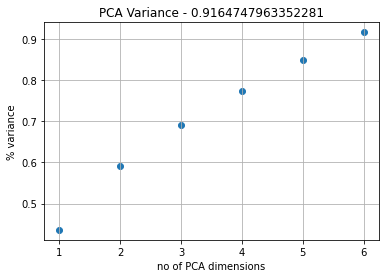

In [13]:
pca_variance_threshold = 0.9

pca = PCA(pca_variance_threshold)
pca.fit(data["x_train"][data["numeric_features"]])

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.title(f"PCA Variance - {np.sum(pca.explained_variance_ratio_)}")
plt.xlabel("no of PCA dimensions") 
plt.ylabel("% variance")
plt.show()

In [40]:
def pca_transformation(pca: PCA, input_data: pd.DataFrame):
    pca_components = pca.transform(input_data[data["numeric_features"]])
    cols = [f"PC{x}" for x in range(1, len(pca.explained_variance_ratio_)+1)]
    pca_df = pd.DataFrame(pca_components, columns=cols, index=input_data.index)
    pca_fransformed = pd.concat([pca_df, input_data[data["categorical_features"]]], axis=1)
    return pca_fransformed

In [41]:
from sklearn import metrics
svc_model = SVC(C=9, gamma=0.1, kernel="rbf")
train_pca = pca_transformation(pca, data["x_train"])
svc_model.fit(train_pca, data["y_train"])

test_pca = pca_transformation(pca, data["x_test"])
predicted = svc_model.predict(test_pca)
print("Accuracy:", metrics.accuracy_score(data["y_test"], predicted))

Accuracy: 0.862015503875969


### Feature Selection forward

In [42]:
for i in range(1, len(data["features"])):
    svc = SVC(C=9, gamma=0.1, kernel="rbf")
    sfs_forward = SequentialFeatureSelector(
        svc, n_features_to_select=i, direction="forward"
    ).fit(data["x_train"], data["y_train"])

    feature_names = list(sfs_forward.get_feature_names_out())
    svc.fit(data["x_train"][feature_names], data["y_train"])
    print(f'No. of features: {len(feature_names)}, Features: {feature_names}, Score: {svc.score(data["x_test"][feature_names], data["y_test"])}')

No. of features: 1, Features: ['acousticness'], Score: 0.5069767441860465


KeyboardInterrupt: 